<a href="https://colab.research.google.com/github/Gusle01/ai_2025/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ------------------------------------------
# 공통: 구종 코드 → 풀네임 매핑
# ------------------------------------------
pitch_type_names = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FA': 'Fastball',
    'FC': 'Cutter',
    'FF': 'Four-Seam Fastball',
    'FS': 'Splitter',
    'SI': 'Sinker',
    'SL': 'Slider',
    'KC': 'Knuckle Curve',
    'ST': 'Sweeper',
    'KN': 'Knuckleball',
    'EP': 'Eephus',
    'FO': 'Forkball'
}

### 📦 필요한 라이브러리 설치 및 불러오기
모델 학습 및 데이터 분석에 필요한 라이브러리들을 설치하고 불러옵니다.

In [2]:
!pip install pybaseball autogluon.tabular scikit-learn xgboost matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast
from datetime import date, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from autogluon.tabular import TabularPredictor

### ⚾ 시즌 연도 입력
분석할 시즌 연도를 사용자로부터 입력받습니다.

In [3]:
try:
    selected_year = int(input("⚾ 분석할 시즌 연도를 입력하세요 (예: 2024): ").strip())
except ValueError:
    print("❌ 숫자를 입력해야 합니다.")
    raise SystemExit

⚾ 분석할 시즌 연도를 입력하세요 (예: 2024): 2025


### 📅 Statcast 데이터 수집
`pybaseball` 라이브러리를 사용하여 입력된 연도의 Statcast 데이터를 월별로 수집합니다. 데이터 수집에는 다소 시간이 걸릴 수 있습니다.

In [4]:
import warnings

dfs = []
print(f"\n📅 {selected_year} 시즌 데이터 수집 중...")

# pybaseball에서 발생하는 FutureWarning를 무시합니다.
warnings.filterwarnings('ignore', category=FutureWarning, module='pybaseball')

for month in range(1, 13):
    start_date = date(selected_year, month, 1)
    end_date = date(selected_year, month + 1, 1) - timedelta(days=1) if month != 12 else date(selected_year, 12, 31)
    s, e = start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")

    try:
        df_temp = statcast(start_dt=s, end_dt=e)
        if not df_temp.empty:
            dfs.append(df_temp)
            print(f"✔ {s} ~ {e} ({len(df_temp)} rows)")
        else:
            print(f"- {s} ~ {e} 데이터 없음")
    except Exception as ex:
        print(f"❌ {s}~{e} 오류: {ex}")

# 경고 필터를 기본값으로 재설정 (선택 사항)
warnings.filterwarnings('default', category=FutureWarning, module='pybaseball')

if not dfs:
    print("❌ 시즌 데이터가 없습니다. 종료합니다.")
    raise SystemExit

data = pd.concat(dfs, ignore_index=True)
print(f"\n✅ 총 데이터 수: {len(data)}")


📅 2025 시즌 데이터 수집 중...
This is a large query, it may take a moment to complete
Skipping offseason dates


0it [00:00, ?it/s]

- 2025-01-01 ~ 2025-01-31 데이터 없음
This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]

- 2025-02-01 ~ 2025-02-28 데이터 없음
This is a large query, it may take a moment to complete


Skipping offseason dates


100%|██████████| 17/17 [00:33<00:00,  1.94s/it]


✔ 2025-03-01 ~ 2025-03-31 (63808 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


✔ 2025-04-01 ~ 2025-04-30 (114767 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:36<00:00,  1.17s/it]


✔ 2025-05-01 ~ 2025-05-31 (120218 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


✔ 2025-06-01 ~ 2025-06-30 (115816 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


✔ 2025-07-01 ~ 2025-07-31 (107305 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:37<00:00,  1.23s/it]


✔ 2025-08-01 ~ 2025-08-31 (124298 rows)
This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:32<00:00,  1.10s/it]


✔ 2025-09-01 ~ 2025-09-30 (111477 rows)
This is a large query, it may take a moment to complete


100%|██████████| 31/31 [00:04<00:00,  6.83it/s]


✔ 2025-10-01 ~ 2025-10-31 (12739 rows)
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 15/15 [00:00<00:00, 20.24it/s]

✔ 2025-11-01 ~ 2025-11-30 (367 rows)
This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]


- 2025-12-01 ~ 2025-12-31 데이터 없음

✅ 총 데이터 수: 770795


### 🎯 투수 목록 출력 및 선택
수집된 데이터에 포함된 투수 목록을 출력하고, 사용자로부터 분석할 투수를 선택받습니다. 이름 또는 ID로 검색할 수 있습니다.

In [5]:
pitchers = data[["pitcher", "player_name"]].drop_duplicates().reset_index(drop=True)
print("\n🎯 현재 시즌에 등장한 투수 목록:")
print("────────────────────────────────────────────")
for i, row in pitchers.iterrows():
    print(f"{i+1:3d}. {row['player_name']:<25} (ID: {row['pitcher']})")
print("────────────────────────────────────────────")
print(f"총 투수 수: {len(pitchers)}명\n")

user_input = input("🔍 투수 이름 또는 ID를 입력하세요 (예: Yamamoto 또는 808967): ").strip()

if user_input.isdigit():
    pitcher_id = int(user_input)
    row = pitchers[pitchers["pitcher"] == pitcher_id]
    if row.empty:
        print("❌ 해당 ID의 투수를 찾을 수 없습니다.")
        raise SystemExit
    pitcher_name = row["player_name"].values[0]
else:
    matched = pitchers[pitchers["player_name"].str.contains(user_input, case=False, na=False)]
    if matched.empty:
        print("❌ 해당 이름의 투수를 찾을 수 없습니다.")
        raise SystemExit
    print("\n🔎 검색 결과:")
    for _, r in matched.iterrows():
        print(f"- {r['player_name']} (ID: {r['pitcher']})")
    try:
        pitcher_id = int(input("\n🎯 위 목록 중 분석할 투수의 ID를 입력하세요: ").strip())
        pitcher_name = matched[matched["pitcher"] == pitcher_id]["player_name"].values[0]
    except Exception:
        print("❌ 잘못된 입력입니다.")
        raise SystemExit

print(f"\n✅ 선택된 투수: {pitcher_name} (ID: {pitcher_id})")


🎯 현재 시즌에 등장한 투수 목록:
────────────────────────────────────────────
  1. Bautista, Félix           (ID: 642585)
  2. Criswell, Cooper          (ID: 681867)
  3. Slaten, Justin            (ID: 686580)
  4. Cano, Yennier             (ID: 666974)
  5. Weissert, Greg            (ID: 669711)
  6. Akin, Keegan              (ID: 669211)
  7. Whitlock, Garrett         (ID: 676477)
  8. Domínguez, Seranthony     (ID: 622554)
  9. Bowman, Matt              (ID: 621199)
 10. Povich, Cade              (ID: 700249)
 11. Newcomb, Sean             (ID: 656794)
 12. Suter, Brent              (ID: 608718)
 13. Duran, Ezequiel           (ID: 677649)
 14. Moll, Sam                 (ID: 594580)
 15. Garabito, Gerson          (ID: 642520)
 16. Singer, Brady             (ID: 663903)
 17. Church, Marc              (ID: 687847)
 18. Rocker, Kumar             (ID: 677958)
 19. Young, Danny              (ID: 664849)
 20. Arias, Luarbert           (ID: 678215)
 21. Brazobán, Huascar         (ID: 623211)
 22. Peter

### 🧹 데이터 전처리
선택된 투수의 데이터만 필터링하고, 구종 예측에 필요한 상황 기반 피처(볼카운트, 주자 상황 등 투구 전에 알 수 있는 정보)를 추출하여 전처리합니다. 희귀 구종은 분석에서 제외됩니다.

In [6]:
df = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()
if df.empty:
    print(f"❌ {selected_year} 시즌에 {pitcher_name} 투구 데이터가 없습니다.")
    raise SystemExit

print(f"{pitcher_name} 투구 수: {len(df)}")

feature_cols = [
    "balls", "strikes",          # 볼카운트
    "outs_when_up", "inning",    # 아웃카운트, 이닝
    "home_score", "away_score",  # 점수
    "on_1b", "on_2b", "on_3b",   # 주자 상황 (0/1)
    "stand", "p_throws"          # 타자/투수 손잡이
]

# 주자 정보 0/1로 변환
for base in ["on_1b", "on_2b", "on_3b"]:
    df[base] = df[base].notna().astype(int)

# stand, p_throws 매핑 (L=0, R=1)
df['stand'] = df['stand'].map({'L': 0, 'R': 1})
df['p_throws'] = df['p_throws'].map({'L': 0, 'R': 1})

# 필요한 컬럼만 남기기
df = df[["pitch_type"] + feature_cols].dropna()

# 희귀 구종 제거 (10구 미만 제거)
pitch_counts = df["pitch_type"].value_counts()
valid_pitches = pitch_counts[pitch_counts >= 10].index
df = df[df["pitch_type"].isin(valid_pitches)].reset_index(drop=True)

print("\n🎯 최종 사용 구종:", df["pitch_type"].unique())
if len(df["pitch_type"].unique()) < 2:
    print("⚠️ 유효 구종이 2종 미만이라 분류 모델 학습이 어렵습니다.")
    raise SystemExit

Yamamoto, Yoshinobu 투구 수: 3315

🎯 최종 사용 구종: ['FS' 'FF' 'CU' 'FC' 'SI' 'SL']


### 📊 데이터 분리 및 인코딩
전처리된 데이터를 훈련 세트와 테스트 세트로 분리하고, XGBoost 모델 학습을 위해 타겟 변수를 숫자형으로 인코딩합니다.

In [7]:
X = df[feature_cols].copy()
y_str = df["pitch_type"].copy()   # 문자열 라벨 그대로 유지

# train/test split
X_train, X_test, y_train_str, y_test_str = train_test_split(
    X, y_str, test_size=0.2, stratify=y_str, random_state=42
)

# AutoGluon / XGBoost 호환을 위해 float32로 변환
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# XGBoost용 숫자 인코딩 (y만 변환)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_str)
y_test_enc = le.transform(y_test_str)
pitch_labels = list(le.classes_)

### 🚀 XGBoost 모델 학습
상황 기반 피처를 사용하여 XGBoost 분류 모델을 학습합니다.

In [8]:
print("\n🚀 XGBoost 모델 학습 중...")

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    random_state=42
)
xgb_model.fit(X_train, y_train_enc)

proba_xgb_raw = xgb_model.predict_proba(X_test)
proba_xgb = pd.DataFrame(proba_xgb_raw, columns=pitch_labels, index=X_test.index)


🚀 XGBoost 모델 학습 중...


### 🤖 AutoGluon Tabular 모델 학습
AutoGluon Tabular를 사용하여 두 번째 분류 모델을 학습합니다. AutoGluon은 다양한 모델을 자동으로 탐색하고 최적화하여 높은 성능을 제공합니다.

In [9]:
print("\n🤖 AutoGluon Tabular 모델 학습 중... (dtype 변환 적용)")

train_ag = X_train.copy()
train_ag["pitch_type"] = y_train_str.values

predictor = TabularPredictor(
    label="pitch_type",
    problem_type="multiclass",
    eval_metric="log_loss",
    path="AutogluonModels/pitchtype"
).fit(
    train_ag,
    presets="medium_quality_faster_train",
    verbosity=0
)

# AutoGluon 확률 예측
proba_ag = predictor.predict_proba(X_test)  # index = X_test.index

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.



🤖 AutoGluon Tabular 모델 학습 중... (dtype 변환 적용)


		`import catboost` failed. A quick tip is to install via `pip install autogluon.tabular[catboost]==1.4.0`.


### 🤝 모델 앙상블 및 성능 평가
XGBoost와 AutoGluon 두 모델의 예측 확률을 결합하여 최종 앙상블 예측을 수행하고, 각 모델과 앙상블 모델의 분류 리포트를 출력하여 성능을 비교합니다.

In [10]:
common_labels = [p for p in proba_ag.columns if p in proba_xgb.columns]

proba_xgb_aligned = proba_xgb[common_labels].values
proba_ag_aligned = proba_ag[common_labels].values

w_xgb = 0.6
w_ag  = 0.4

proba_ensemble = w_xgb * proba_xgb_aligned + w_ag * proba_ag_aligned

idx_max = np.argmax(proba_ensemble, axis=1)
final_pred_labels = np.array(common_labels)[idx_max]

print("\n============================")
print("📊 XGBoost 단일 모델 리포트")
print("============================")
xgb_pred_labels = le.inverse_transform(np.argmax(proba_xgb_raw, axis=1))
print(classification_report(y_test_str, xgb_pred_labels, zero_division=0))

print("\n===============================")
print("📊 AutoGluon Tabular 리포트")
print("===============================")
ag_pred_labels = predictor.predict(X_test)
print(classification_report(y_test_str, ag_pred_labels, zero_division=0))

print("\n====================================")
print("📊 XGBoost + AutoGluon 앙상블 리포트")
print("====================================")
print(classification_report(y_test_str, final_pred_labels, zero_division=0))


📊 XGBoost 단일 모델 리포트
              precision    recall  f1-score   support

          CU       0.21      0.17      0.19       122
          FC       0.16      0.10      0.12        73
          FF       0.41      0.48      0.44       228
          FS       0.36      0.42      0.39       172
          SI       0.26      0.20      0.23        49
          SL       0.12      0.05      0.07        19

    accuracy                           0.33       663
   macro avg       0.25      0.24      0.24       663
weighted avg       0.31      0.33      0.32       663


📊 AutoGluon Tabular 리포트
              precision    recall  f1-score   support

          CU       0.15      0.04      0.06       122
          FC       0.11      0.03      0.04        73
          FF       0.44      0.60      0.51       228
          FS       0.41      0.65      0.50       172
          SI       0.07      0.04      0.05        49
          SL       0.00      0.00      0.00        19

    accuracy                   

### 📉 앙상블 혼동 행렬 시각화
앙상블 모델의 예측 결과를 혼동 행렬(Confusion Matrix)로 시각화하여 어떤 구종을 혼동하는지 한눈에 파악합니다.

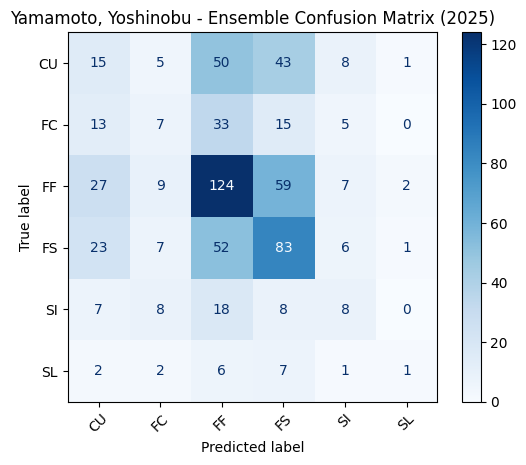

In [11]:
cm = confusion_matrix(y_test_str, final_pred_labels, labels=common_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=common_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"{pitcher_name} - Ensemble Confusion Matrix ({selected_year})")
plt.show()

### 🎯 특정 볼카운트별 모델 정확도 비교
자주 등장하는 특정 볼카운트 상황(예: 2-0, 1-2, 3-2 등)에서 각 모델과 앙상블 모델의 정확도를 비교합니다.

In [12]:
print("\n🎯 특정 볼카운트별 모델 정확도 비교")

counts_to_check = [
    (2, 0),  # 2-0 카운트
    (1, 2),  # 1-2 카운트
    (3, 2),  # 풀카운트
    (0, 0),  # 0-0
]

results = []

xgb_series = pd.Series(xgb_pred_labels, index=X_test.index)
ag_series  = pd.Series(ag_pred_labels,   index=X_test.index)
ens_series = pd.Series(final_pred_labels, index=X_test.index)

for balls, strikes in counts_to_check:
    idx = X_test[(X_test['balls'] == balls) & (X_test['strikes'] == strikes)].index

    if len(idx) == 0:
        print(f"\n⚠️ {balls}-{strikes} 카운트 데이터가 테스트셋에 없습니다. (건너뜀)")
        continue

    y_true = y_test_str.loc[idx]
    y_pred_xgb = xgb_series.loc[idx]
    y_pred_ag  = ag_series.loc[idx]
    y_pred_ens = ens_series.loc[idx]

    acc_xgb = (y_true == y_pred_xgb).mean()
    acc_ag  = (y_true == y_pred_ag).mean()
    acc_ens = (y_true == y_pred_ens).mean()

    results.append({
        "count": f"{balls}-{strikes}",
        "n_samples": len(idx),
        "acc_xgb": acc_xgb,
        "acc_ag": acc_ag,
        "acc_ensemble": acc_ens,
    })

if results:
    acc_df = pd.DataFrame(results).set_index("count")
    print("\n📊 볼카운트별 정확도 비교")
    print(acc_df.to_string(formatters={
        "n_samples": lambda x: f"{x:d}",
        "acc_xgb": lambda x: f"{x:.3f}",
        "acc_ag": lambda x: f"{x:.3f}",
        "acc_ensemble": lambda x: f"{x:.3f}",
    }))
else:
    print("\n⚠️ 지정한 카운트들에 대해 유효한 테스트 데이터가 없습니다.")


🎯 특정 볼카운트별 모델 정확도 비교

📊 볼카운트별 정확도 비교
      n_samples acc_xgb acc_ag acc_ensemble
count                                      
2-0          24   0.583  0.583        0.542
1-2          62   0.306  0.371        0.323
3-2          29   0.379  0.414        0.448
0-0         195   0.415  0.410        0.431


### 📘 모든 볼카운트별 앙상블 예측 테이블
모든 가능한 볼카운트 상황(3볼 2스트라이크 등)에서 앙상블 모델이 가장 많이 예측한 구종을 테이블 형태로 정리하여 보여줍니다. 실제 경기 운영 시 참고할 수 있습니다.

In [13]:
print("\n==============================")
print("🎯 모든 볼카운트별 모델 예측 결과 (Ensemble)")
print("==============================")

all_counts = [(b, s) for b in range(0, 4) for s in range(0, 3)]
rows = []

for balls, strikes in all_counts:
    idx = X_test[(X_test['balls'] == balls) & (X_test['strikes'] == strikes)].index

    if len(idx) == 0:
        most_ens = "(데이터 없음)"
        samples = 0
    else:
        most_ens = ens_series.loc[idx].mode()[0]
        samples = len(idx)

    rows.append({
        "count": f"{balls}-{strikes}",
        "samples": samples,
        "Ensemble_pred": most_ens
    })

count_pred_df = pd.DataFrame(rows)
print("\n📘 모든 볼카운트별 Ensemble 예측 결과")
print(count_pred_df.to_string(index=False))


🎯 모든 볼카운트별 모델 예측 결과 (Ensemble)

📘 모든 볼카운트별 Ensemble 예측 결과
count  samples Ensemble_pred
  0-0      195            FF
  0-1       88            FS
  0-2       37            FS
  1-0       61            FF
  1-1       65            FS
  1-2       62            FS
  2-0       24            FF
  2-1       29            FC
  2-2       54            FS
  3-0        6            FF
  3-1       13            FF
  3-2       29            FF


### 📊 볼카운트별 실제 vs 예측 구종 분포 Heatmap
실제 구종 분포와 XGBoost, AutoGluon, 앙상블 모델의 예측 구종 분포를 볼카운트별 히트맵으로 시각화하여 모델의 경향성을 파악합니다.


📊 볼카운트별 실제/예측 비교 Heatmap 생성 중...



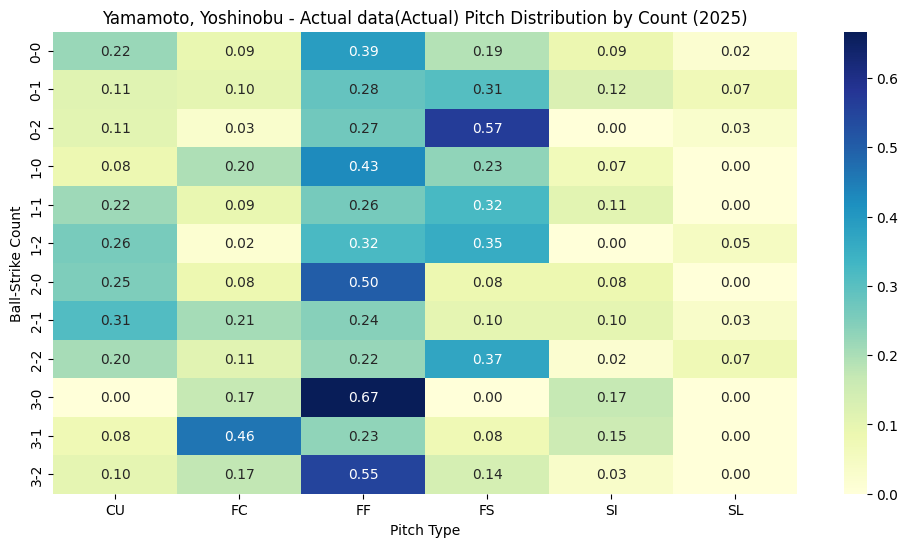

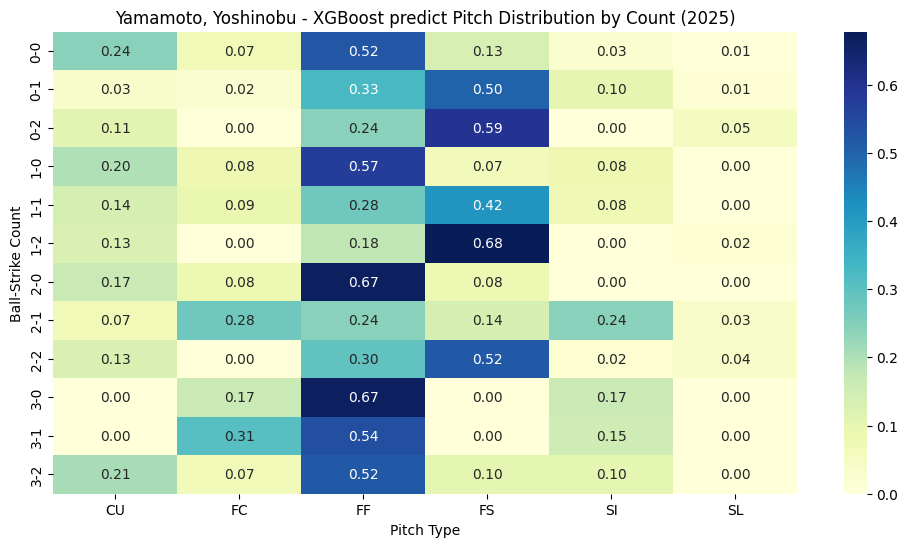

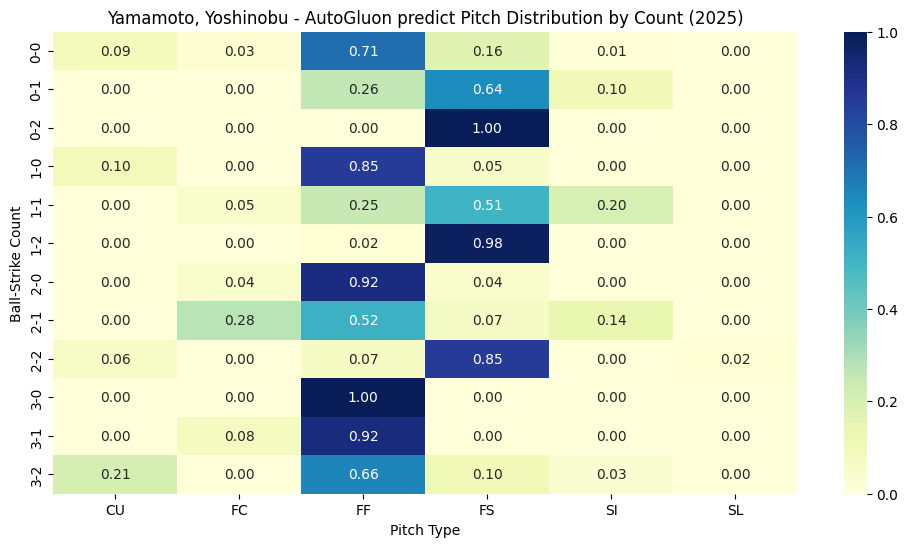

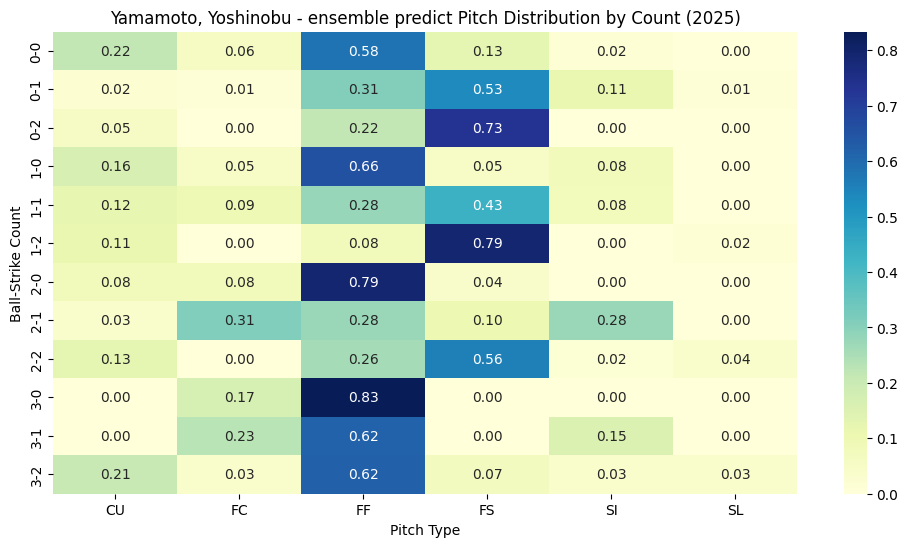

In [14]:
print("\n📊 볼카운트별 실제/예측 비교 Heatmap 생성 중...\n")

heatmap_rows = []
all_counts = [(b, s) for b in range(4) for s in range(3)]

for balls, strikes in all_counts:
    count_label = f"{balls}-{strikes}"
    true_idx = X_test[(X_test["balls"] == balls) & (X_test["strikes"] == strikes)].index
    true_count = y_test_str.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)

    pred_xgb = xgb_series.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)
    pred_ag  = ag_series.loc[true_idx]  if len(true_idx) > 0 else pd.Series([], dtype=str)
    pred_ens = ens_series.loc[true_idx] if len(true_idx) > 0 else pd.Series([], dtype=str)

    def get_ratio(series):
        total = len(series)
        if total == 0:
            return {pitch: 0.0 for pitch in common_labels}
        cnt = series.value_counts(normalize=True)
        return {pitch: cnt.get(pitch, 0.0) for pitch in common_labels}

    heatmap_rows.append({
        "count": count_label,
        **{f"true_{p}": r for p, r in get_ratio(true_count).items()},
        **{f"xgb_{p}": r for p, r in get_ratio(pred_xgb).items()},
        **{f"ag_{p}": r for p, r in get_ratio(pred_ag).items()},
        **{f"ens_{p}": r for p, r in get_ratio(pred_ens).items()},
    })

heatmap_df = pd.DataFrame(heatmap_rows)

sections = {
    "Actual data(Actual)": [col for col in heatmap_df.columns if col.startswith("true_")],
    "XGBoost predict":       [col for col in heatmap_df.columns if col.startswith("xgb_")],
    "AutoGluon predict":    [col for col in heatmap_df.columns if col.startswith("ag_")],
    "ensemble predict":        [col for col in heatmap_df.columns if col.startswith("ens_")],
}

for title, cols in sections.items():
    sub_df = heatmap_df.set_index("count")[cols]
    sub_df.columns = [c.split("_", 1)[1] for c in cols]

    plt.figure(figsize=(12, 6))
    sns.heatmap(sub_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - {title} Pitch Distribution by Count ({selected_year})")
    plt.xlabel("Pitch Type")
    plt.ylabel("Ball-Strike Count")
    plt.show()

### ⚾️ 좌타 / 우타 별 볼카운트 × 구종 Heatmap (실제 데이터)
타자의 좌우 스탠스에 따른 실제 구종 분포를 볼카운트별로 히트맵을 통해 시각화합니다. 투수가 좌타자와 우타자를 상대할 때 어떤 구종을 선호하는지 파악할 수 있습니다.


📊 좌타 / 우타 별 볼카운트 × 구종 분포 Heatmap 생성 중...


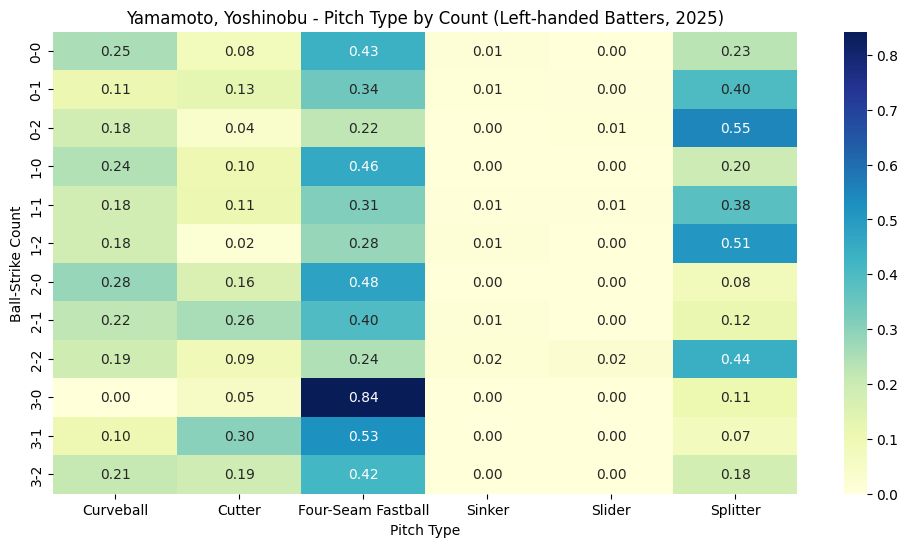

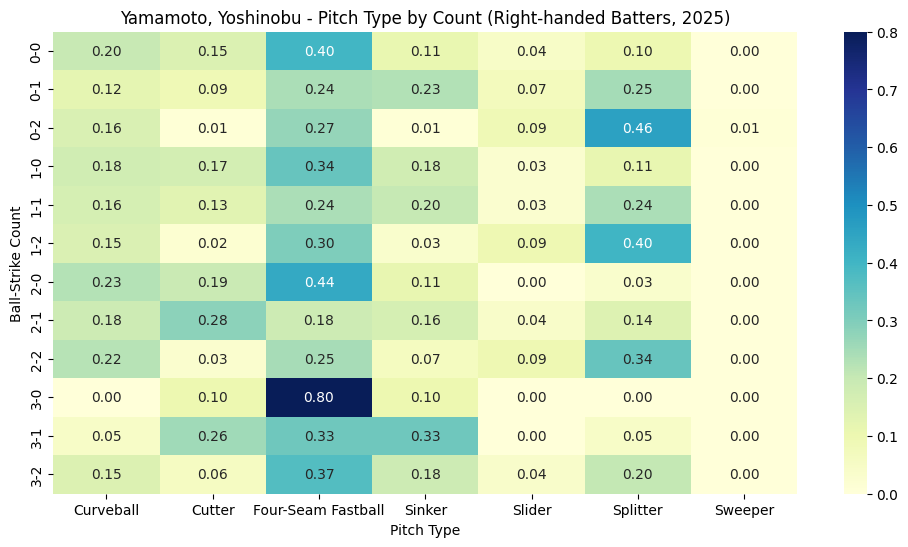

In [15]:
print("\n📊 좌타 / 우타 별 볼카운트 × 구종 분포 Heatmap 생성 중...")

df_lr = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()
df_lr = df_lr[['pitch_type', 'balls', 'strikes', 'stand']].dropna()
df_lr = df_lr[(df_lr['balls'] <= 3) & (df_lr['strikes'] <= 2)]
df_lr['count'] = df_lr['balls'].astype(str) + '-' + df_lr['strikes'].astype(str)
df_lr['pitch_type_full'] = df_lr['pitch_type'].map(pitch_type_names).fillna(df_lr['pitch_type'])

for hand, label in [('L', 'Left-handed Batters'), ('R', 'Right-handed Batters')]:
    sub = df_lr[df_lr['stand'] == hand]
    if sub.empty:
        print(f"\n⚠️ {label} 데이터가 없습니다.")
        continue

    count_pitch = pd.crosstab(
        sub['count'],
        sub['pitch_type_full'],
        normalize='index'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(count_pitch, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Pitch Type by Count ({label}, {selected_year})")
    plt.xlabel("Pitch Type")
    plt.ylabel("Ball-Strike Count")
    plt.show()

### 🏃 주자 상황 × 볼카운트 × 구종 Heatmap (실제 데이터)
주자 상황(주자 없음, 1루, 만루 등)에 따른 실제 구종 분포를 볼카운트별로 시각화합니다. 주자가 있을 때 투수가 어떤 구종을 던지는지 분석할 수 있습니다.


📊 주자 상황 × 볼카운트 × 구종 Heatmap 생성 중...


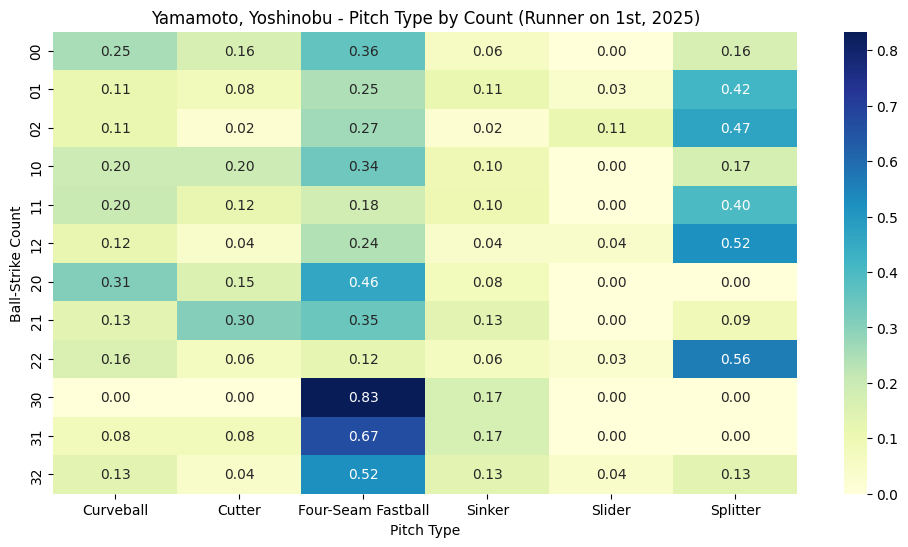

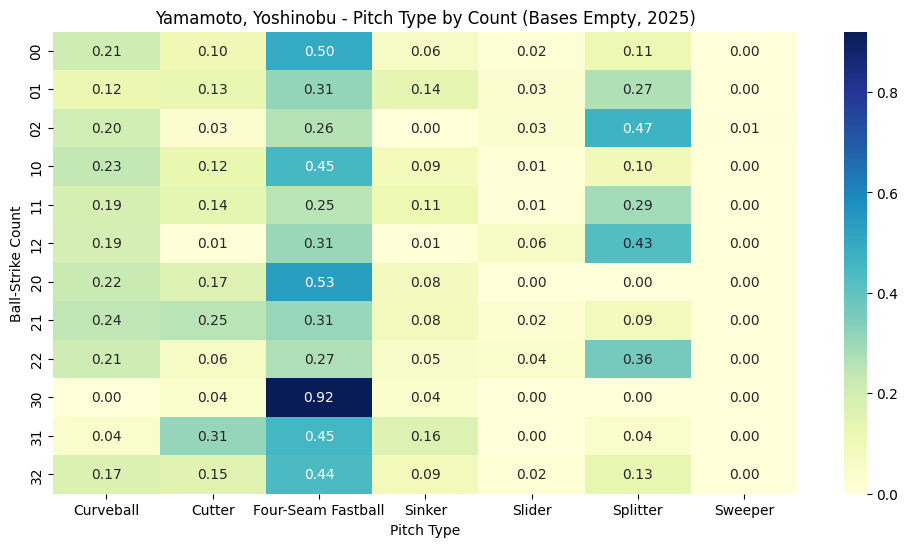

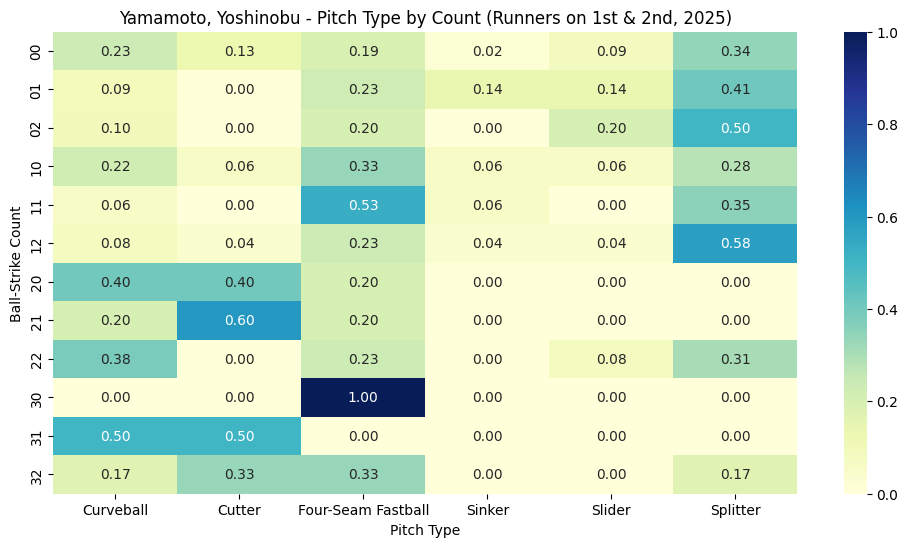

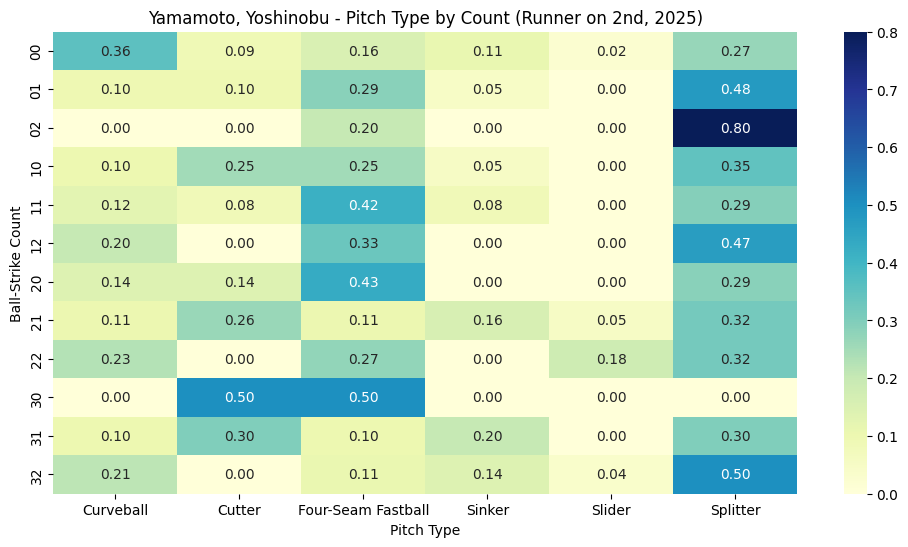

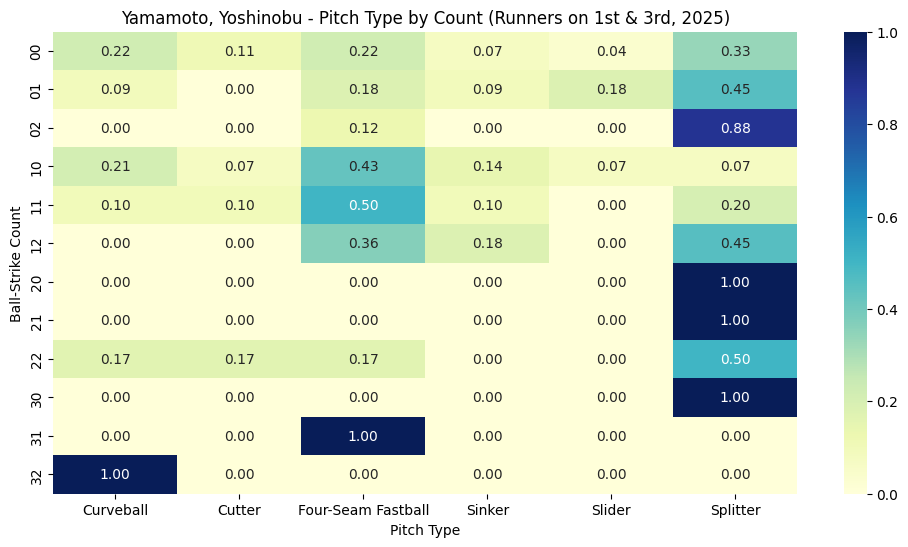

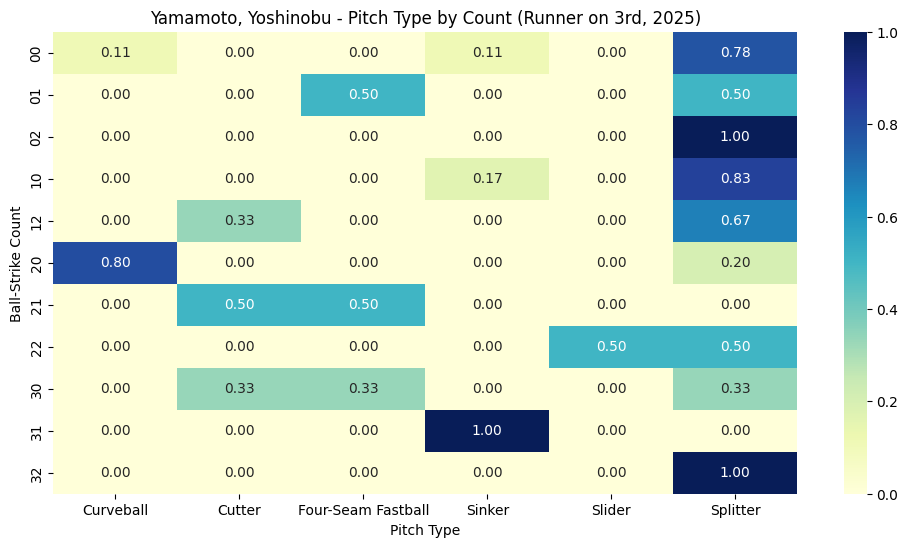

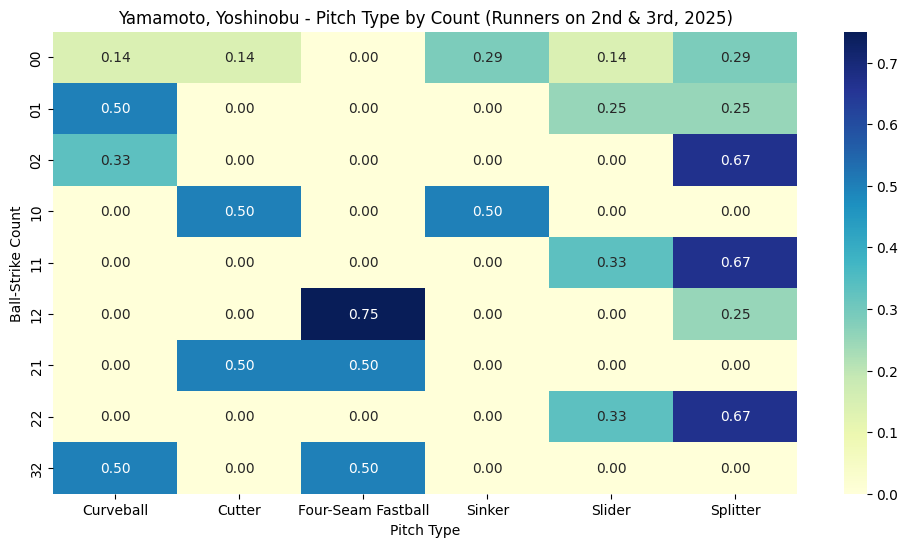

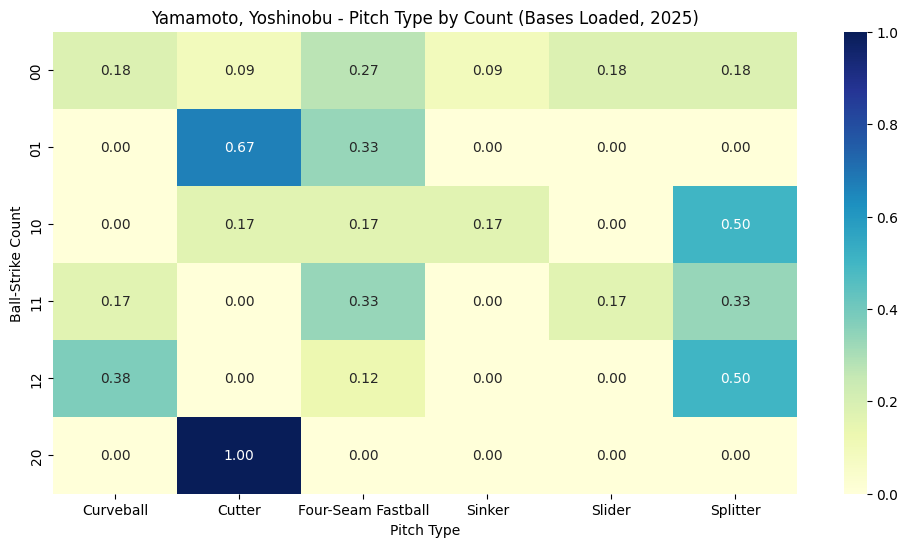

In [16]:
print("\n📊 주자 상황 × 볼카운트 × 구종 Heatmap 생성 중...")

df_bases = data[(data["pitcher"] == pitcher_id) & (data["pitch_type"].notna())].copy()
df_bases = df_bases[['pitch_type', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b']].dropna(subset=['pitch_type'])

for b in ['on_1b', 'on_2b', 'on_3b']:
    df_bases[b] = df_bases[b].apply(lambda x: 0 if pd.isna(x) else 1)

df_bases = df_bases[(df_bases['balls'] <= 3) & (df_bases['strikes'] <= 2)]
df_bases['count'] = df_bases['balls'].astype(str) + df_bases['strikes'].astype(str)

def base_state(row):
    return f"{'-' if row['on_1b'] == 0 else '1'}" + \
           f"{'-' if row['on_2b'] == 0 else '2'}" + \
           f"{'-' if row['on_3b'] == 0 else '3'}"

df_bases['base_state'] = df_bases.apply(base_state, axis=1)

base_state_label = {
    '---': 'Bases Empty',
    '1--': 'Runner on 1st',
    '-2-': 'Runner on 2nd',
    '--3': 'Runner on 3rd',
    '12-': 'Runners on 1st & 2nd',
    '1-3': 'Runners on 1st & 3rd',
    '-23': 'Runners on 2nd & 3rd',
    '123': 'Bases Loaded'
}

df_bases['base_state_label'] = df_bases['base_state'].map(base_state_label).fillna(df_bases['base_state'])
df_bases['pitch_type_full'] = df_bases['pitch_type'].map(pitch_type_names).fillna(df_bases['pitch_type'])

for bs in df_bases['base_state_label'].unique():
    sub = df_bases[df_bases['base_state_label'] == bs]
    if sub.empty:
        continue

    count_pitch = pd.crosstab(
        sub['count'],
        sub['pitch_type_full'],
        normalize='index'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(count_pitch, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Pitch Type by Count ({bs}, {selected_year})")
    plt.xlabel("Pitch Type")
    plt.ylabel("Ball-Strike Count")
    plt.show()

###📊 2D Heatmap: Count × Base State × BatterSide 앙상블 정확도 분석

이 분석 파트는 주자 상황(Base State), 타자의 스탠스(좌/우타), 그리고 볼카운트(B-S Count)를 조합하여
앙상블 모델(XGBoost + AutoGluon)의 예측 정확도(실제 구종 = 예측 구종 비율)를
2차원 Heatmap으로 시각화한 것입니다.


📊 2D Heatmap: Count × Base State × BatterSide 정확도 생성 중...


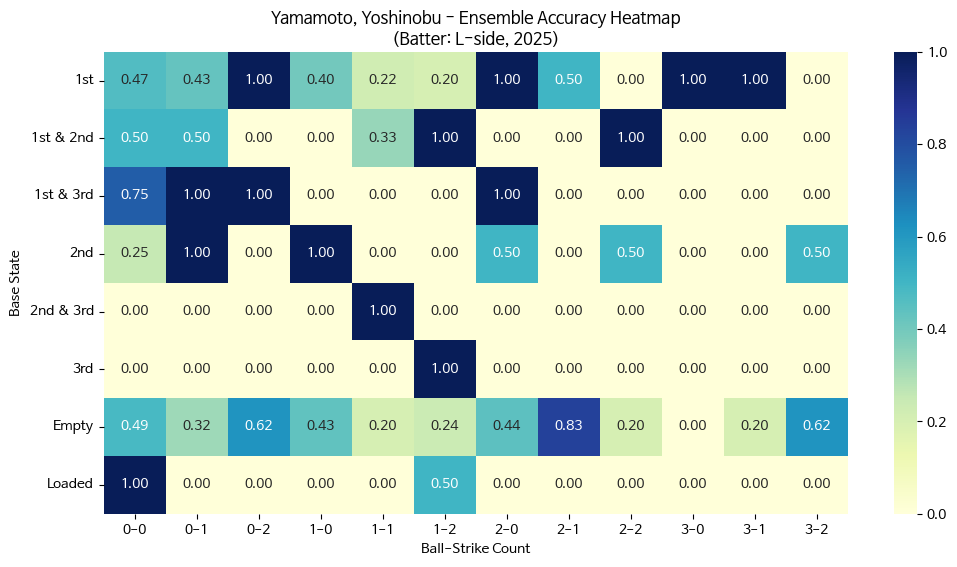

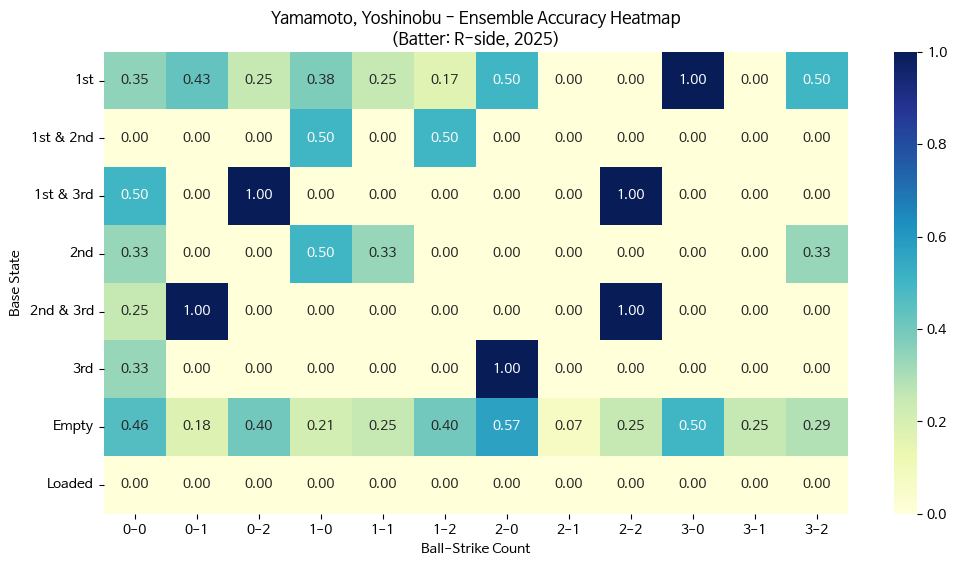

In [31]:
print("\n📊 2D Heatmap: Count × Base State × BatterSide 정확도 생성 중...")

eval_df = X_test.copy()
eval_df["true"] = y_test_str
eval_df["pred_ens"] = ens_series
eval_df["correct"] = (eval_df["true"] == eval_df["pred_ens"]).astype(float)

# 주자 여부 0/1 → 문자열 변환
def base_state(row):
    s1 = '1' if row['on_1b'] else '-'
    s2 = '2' if row['on_2b'] else '-'
    s3 = '3' if row['on_3b'] else '-'
    return s1 + s2 + s3

eval_df["base_state"] = eval_df.apply(base_state, axis=1)

# 보기 좋게 라벨링
base_state_label = {
    '---': 'Empty',
    '1--': '1st',
    '-2-': '2nd',
    '--3': '3rd',
    '12-': '1st & 2nd',
    '1-3': '1st & 3rd',
    '-23': '2nd & 3rd',
    '123': 'Loaded'
}

eval_df["base_label"] = eval_df["base_state"].map(base_state_label).fillna("Unknown")

# 좌/우타 라벨
eval_df["stand_label"] = eval_df["stand"].map({0: "L", 1: "R"})
eval_df["count"] = eval_df["balls"].astype(int).astype(str) + "-" + eval_df["strikes"].astype(int).astype(str)

# 🔥 좌/우타자 분리 출력
for hand in ["L", "R"]:
    sub = eval_df[eval_df["stand_label"] == hand]
    if sub.empty:
        print(f"⚠️ {hand}-side 데이터 없음")
        continue

    heat = sub.pivot_table(
        index="base_label",     # ← 바뀐 부분
        columns="count",
        values="correct",
        aggfunc="mean"
    ).fillna(0)

    # Heatmap 표시
    plt.figure(figsize=(12, 6))
    sns.heatmap(heat, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Ensemble Accuracy Heatmap\n(Batter: {hand}-side, {selected_year})")
    plt.xlabel("Ball-Strike Count")
    plt.ylabel("Base State")
    plt.show()

### 🔄 실시간 구종 예측 함수
주어진 경기 상황(볼카운트, 이닝, 점수, 주자 유무, 타자 및 투수 손잡이)을 입력받아 투수의 구종별 예측 확률을 반환하는 함수를 정의합니다. 실제 경기 중 특정 상황에서 어떤 구종이 나올지 예측하는 데 활용할 수 있습니다.

In [19]:
def predict_pitch_realtime(
    balls,
    strikes,
    outs_when_up,
    inning,
    home_score,
    away_score,
    on_1b,
    on_2b,
    on_3b,
    stand,      # 'L' or 'R'
    p_throws,   # 'L' or 'R'
    w_xgb=0.6,
    w_ag=0.4
):
    """
    현재 경기 상황(볼카운트, 이닝, 점수, 주자, 타자/투수 손잡이)을 넣으면
    XGBoost + AutoGluon 앙상블로 구종별 예측 확률을 출력하는 함수.
    """
    input_df = pd.DataFrame([{
        "balls": balls,
        "strikes": strikes,
        "outs_when_up": outs_when_up,
        "inning": inning,
        "home_score": home_score,
        "away_score": away_score,
        "on_1b": int(bool(on_1b)),
        "on_2b": int(bool(on_2b)),
        "on_3b": int(bool(on_3b)),
        "stand": 0 if stand == "L" else 1,
        "p_throws": 0 if p_throws == "L" else 1
    }])

    input_df = input_df[feature_cols].astype(np.float32)

    proba_x = xgb_model.predict_proba(input_df)
    proba_a = predictor.predict_proba(input_df)

    proba_x_df = pd.DataFrame(proba_x, columns=pitch_labels)
    proba_a_df = proba_a[pitch_labels]

    final_probs = w_xgb * proba_x_df.values + w_ag * proba_a_df.values
    final_probs = final_probs[0]

    result = pd.DataFrame({
        "pitch_code": pitch_labels,
        "pitch_name": [pitch_type_names.get(p, p) for p in pitch_labels],
        "probability": final_probs
    }).sort_values("probability", ascending=False)

    print(f"\n🎯 현재 상황에서 {pitcher_name}의 구종 예측 (앙상블, {selected_year})")
    print(result.to_string(index=False, formatters={"probability": lambda x: f"{x:.3f}"}))

    return result

In [24]:
predict_pitch_realtime(
    balls=2,
    strikes=1,
    outs_when_up=1,
    inning=5,
    home_score=3,
    away_score=2,
    on_1b=True,
    on_2b=False,
    on_3b=False,
    stand="L",
    p_throws="R"
)


🎯 현재 상황에서 Yamamoto, Yoshinobu의 구종 예측 (앙상블, 2025)
pitch_code         pitch_name probability
        FF Four-Seam Fastball       0.392
        FS           Splitter       0.306
        FC             Cutter       0.147
        CU          Curveball       0.141
        SI             Sinker       0.008
        SL             Slider       0.005


,pitch_code,pitch_name,probability
2,FF,Four-Seam Fastball,0.392331
3,FS,Splitter,0.306046
1,FC,Cutter,0.147333
0,CU,Curveball,0.141409
4,SI,Sinker,0.007781
5,SL,Slider,0.005100


### 📊 볼카운트별 앙상블 예측 구종 분포 (확률)
모든 볼카운트별로 앙상블 모델이 예측하는 구종별 확률 분포를 테이블과 히트맵으로 시각화합니다. 이는 투수의 구종 선택 전략을 이해하는 데 도움이 됩니다.


📊 볼카운트별 앙상블 예측 구종 분포(확률) 계산 중...

📘 볼카운트별 앙상블 예측 확률 테이블:
      Curveball Cutter Four-Seam Fastball Splitter Sinker Slider
count                                                           
0-0        0.13   0.07               0.65     0.13   0.02   0.00
0-1        0.15   0.15               0.40     0.26   0.02   0.01
0-2        0.24   0.04               0.20     0.49   0.01   0.02
1-0        0.20   0.07               0.60     0.12   0.01   0.00
1-1        0.24   0.13               0.26     0.33   0.02   0.01
1-2        0.35   0.03               0.17     0.42   0.01   0.02
2-0        0.30   0.11               0.53     0.03   0.03   0.00
2-1        0.30   0.17               0.37     0.12   0.04   0.01
2-2        0.26   0.06               0.33     0.30   0.03   0.02
3-0        0.04   0.05               0.90     0.01   0.01   0.00
3-1        0.10   0.24               0.58     0.05   0.03   0.00
3-2        0.33   0.15               0.37     0.10   0.04   0.01


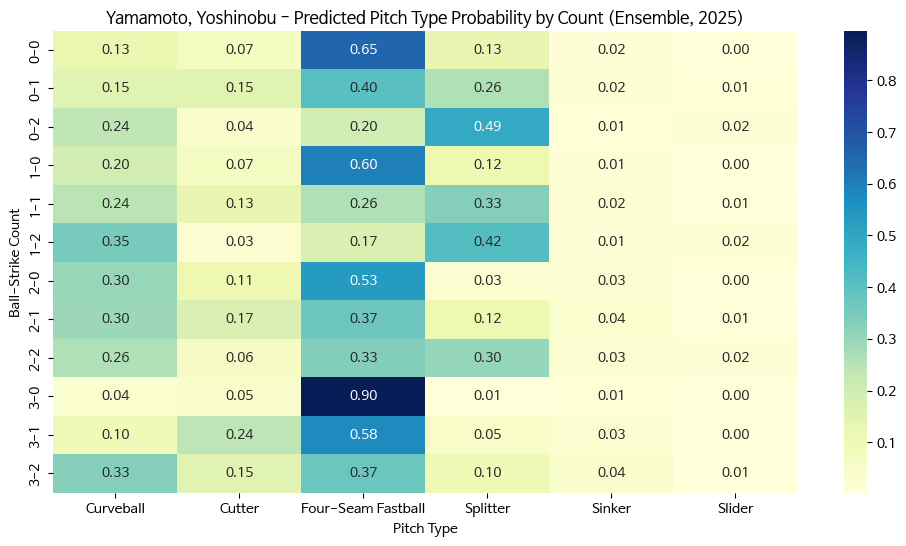

In [20]:
import itertools

print("\n📊 볼카운트별 앙상블 예측 구종 분포(확률) 계산 중...")

# feature_cols 중 groupby에 넣으면 안 되는 컬럼 제거
# balls/strikes는 groupby 기준으로 사용하기 때문에 제외
group_feature_cols = [c for c in feature_cols if c not in ['balls', 'strikes']]

# 1) 볼카운트별 평균 피처 계산
count_feature_df = (
    df.groupby(['balls', 'strikes'])[group_feature_cols]
      .mean()
      .reset_index()
)

if count_feature_df.empty:
    print("⚠️ 볼카운트별 평균 피처를 계산할 수 없습니다. 데이터 부족.")
else:
    pred_rows = []

    # AutoGluon 라벨
    ag_labels = list(predictor.class_labels)
    common_labels = [p for p in ag_labels if p in pitch_labels]

    for _, row in count_feature_df.iterrows():
        balls = int(row['balls'])
        strikes = int(row['strikes'])

        # 2) 평균 피처 → 모델 입력 형태로 변환
        input_df = row[group_feature_cols].to_frame().T.astype(np.float32)

        # 3) ✔ balls/strikes 다시 넣어주기 (핵심 수정!)
        input_df.insert(0, "balls", balls)
        input_df.insert(1, "strikes", strikes)

        # 4) ✔ 학습 때 사용한 feature 순서와 정확히 일치시키기
        input_df = input_df[X_train.columns]

        # 5) 모델 예측
        proba_x = xgb_model.predict_proba(input_df)
        proba_a = predictor.predict_proba(input_df)

        # 6) 공통 라벨 기준 정렬
        proba_x_df = pd.DataFrame(proba_x, columns=pitch_labels)[common_labels]
        proba_a_df = proba_a[common_labels]

        # 7) 앙상블 확률
        final_probs = 0.6 * proba_x_df.values + 0.4 * proba_a_df.values
        final_probs = final_probs[0]

        # 8) 저장
        row_dict = {"count": f"{balls}-{strikes}"}
        for code, prob in zip(common_labels, final_probs):
            row_dict[pitch_type_names.get(code, code)] = prob

        pred_rows.append(row_dict)

    # DF로 정리
    pred_count_df = (
        pd.DataFrame(pred_rows)
          .set_index("count")
          .sort_index()
          .fillna(0)
    )

    # 출력
    print("\n📘 볼카운트별 앙상블 예측 확률 테이블:")
    print(pred_count_df.to_string(formatters={c: lambda x: f"{x:.2f}" for c in pred_count_df.columns}))

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pred_count_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{pitcher_name} - Predicted Pitch Type Probability by Count (Ensemble, {selected_year})")
    plt.xlabel("Pitch Type")
    plt.ylabel("Ball-Strike Count")
    plt.show()

### 📋 모든 상황(Count × Base × Stand) 전략 시트 생성
모든 가능한 경기 상황(볼카운트, 주자 상황, 타자 스탠스)에 대한 1, 2순위 예측 구종과 그 확률을 계산하여 전략 시트를 생성하고 CSV 파일로 저장합니다. 이는 경기 중 실시간 전략 수립에 매우 유용합니다.

In [21]:
import itertools

print("\n📊 모든 가능한 경기 상황에 대한 '구종 전략 시트' 생성 중... (Batch Prediction)")

# 1. 고정 변수
fixed_feats = {
    "outs_when_up": 0,
    "inning": 1,
    "home_score": 0,
    "away_score": 0,
    "p_throws": df['p_throws'].iloc[0]
}

# 2. 변수 범위 설정
balls_range = [0, 1, 2, 3]
strikes_range = [0, 1, 2]
stand_range = [0, 1]  # 0: 좌타, 1: 우타

runner_states = [
    (0, 0, 0), # 주자 없음
    (1, 0, 0), # 1루
    (0, 1, 0), # 2루
    (0, 0, 1), # 3루
    (1, 1, 0), # 1,2루
    (1, 0, 1), # 1,3루
    (0, 1, 1), # 2,3루
    (1, 1, 1)  # 만루
]

# 3. 모든 조합 생성 (192가지)
combinations = list(itertools.product(stand_range, runner_states, balls_range, strikes_range))

# 4. 입력 데이터프레임 생성
batch_rows = []
for stand, (r1, r2, r3), b, s in combinations:
    row = fixed_feats.copy()
    row.update({
        "balls": b, "strikes": s, "stand": stand,
        "on_1b": r1, "on_2b": r2, "on_3b": r3
    })
    batch_rows.append(row)

batch_df = pd.DataFrame(batch_rows)
batch_df = batch_df[X_train.columns].astype(np.float32)

# 5. 일괄 예측 (Batch Prediction)
print(f"🚀 총 {len(batch_df)}개 상황에 대해 일괄 예측 수행...")
proba_x = xgb_model.predict_proba(batch_df)
proba_a = predictor.predict_proba(batch_df)

ag_labels = list(predictor.class_labels)
common_labels = [p for p in ag_labels if p in pitch_labels]

proba_x_df = pd.DataFrame(proba_x, columns=pitch_labels)[common_labels]
proba_a_df = proba_a[common_labels]

final_probs = 0.6 * proba_x_df.values + 0.4 * proba_a_df.values

# 6. 결과 정리
strategy_data = []

for i, (stand, (r1, r2, r3), b, s) in enumerate(combinations):
    probs = final_probs[i]
    sorted_idx = np.argsort(probs)[::-1]

    top1_code = common_labels[sorted_idx[0]]
    top1_prob = probs[sorted_idx[0]]

    # 2순위가 있을 때만 가져오기
    if len(common_labels) > 1:
        top2_code = common_labels[sorted_idx[1]]
        top2_prob = probs[sorted_idx[1]]
    else:
        top2_code = ""
        top2_prob = 0.0

    # 라벨링
    batter_str = "우타자(R)" if stand == 1 else "좌타자(L)"
    runner_str = ""
    if r1==0 and r2==0 and r3==0: runner_str = "주자 없음"
    elif r1==1 and r2==1 and r3==1: runner_str = "만루"
    else:
        base_list = []
        if r1: base_list.append("1루")
        if r2: base_list.append("2루")
        if r3: base_list.append("3루")
        runner_str = ",".join(base_list)

    strategy_data.append({
        "타자": batter_str,
        "주자": runner_str,
        "볼카운트": f"{b}-{s}",
        "1순위": pitch_type_names.get(top1_code, top1_code),
        "1순위_확률": f"{top1_prob:.1%}",
        "2순위": pitch_type_names.get(top2_code, top2_code),
        "2순위_확률": f"{top2_prob:.1%}"
    })

strategy_df = pd.DataFrame(strategy_data)

# CSV 저장
filename = f"{pitcher_name}_full_strategy_{selected_year}.csv"
strategy_df.to_csv(filename, index=False, encoding='utf-8-sig')
print(f"💾 전체 데이터 저장 완료: {filename}")


📊 모든 가능한 경기 상황에 대한 '구종 전략 시트' 생성 중... (Batch Prediction)
🚀 총 192개 상황에 대해 일괄 예측 수행...
💾 전체 데이터 저장 완료: Yamamoto, Yoshinobu_full_strategy_2025.csv


### 📈 우타자/좌타자 상황별 1,2순위 통합 요약표 출력
생성된 전략 시트를 기반으로 우타자와 좌타자 각각에 대한 볼카운트별 1, 2순위 추천 구종을 요약하여 표로 출력합니다. 이는 투수 코치나 선수들이 전략을 수립하는 데 직관적인 도움을 줄 수 있습니다.

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 30)

runner_order = ['주자 없음', '1루', '2루', '3루', '1루,2루', '1루,3루', '2루,3루', '만루']

# 우타자, 좌타자 각각 반복해서 표 생성
for batter_type in ['우타자(R)', '좌타자(L)']:
    print(f"\n{'='*60}")
    print(f"⚾ [{batter_type}] 상황별 추천 구종 (1순위 / 2순위)")
    print(f"{'='*60}")

    # 해당 타자 데이터 필터링
    sub_df = strategy_df[strategy_df['타자'] == batter_type].copy()

    # 1순위와 2순위를 한 칸에 합치기 (예: "직구 / 슬라이더")
    # 확률까지 넣으면 너무 길어지므로 구종 이름만 병기함
    sub_df['Combined'] = sub_df.apply(
        lambda x: f"{x['1순위']} / {x['2순위']}" if x['2순위'] else x['1순위'],
        axis=1
    )

    # 피벗 테이블 생성
    pivot = sub_df.pivot(index='주자', columns='볼카운트', values='Combined')

    # 주자 순서 정렬
    pivot = pivot.reindex(runner_order)

    # 출력
    print(pivot.fillna('-'))
    print("\n")


⚾ [우타자(R)] 상황별 추천 구종 (1순위 / 2순위)
볼카운트                             0-0                            0-1                            0-2                          1-0                          1-1                            1-2                            2-0                2-1                            2-2                            3-0                            3-1                            3-2
주자                                                                                                                                                                                                                                                                                                                                                                       
주자 없음    Four-Seam Fastball / Sinker  Splitter / Four-Seam Fastball  Splitter / Four-Seam Fastball  Four-Seam Fastball / Sinker            Sinker / Splitter  Splitter / Four-Seam Fastball    Four-Seam Fastball / Cutter    Cutter / Sinker  Spl

### 🎨 우타자 vs 좌타자 전략 비교 시각화 (영문 버전)
투수와 타자 간의 구종 전략을 시각적으로 비교하기 위해 우타자와 좌타자 각각에 대한 추천 구종 시트를 영문으로 변환하여 표 형태로 보여줍니다. 이는 국제적인 야구 환경에서도 활용될 수 있습니다.

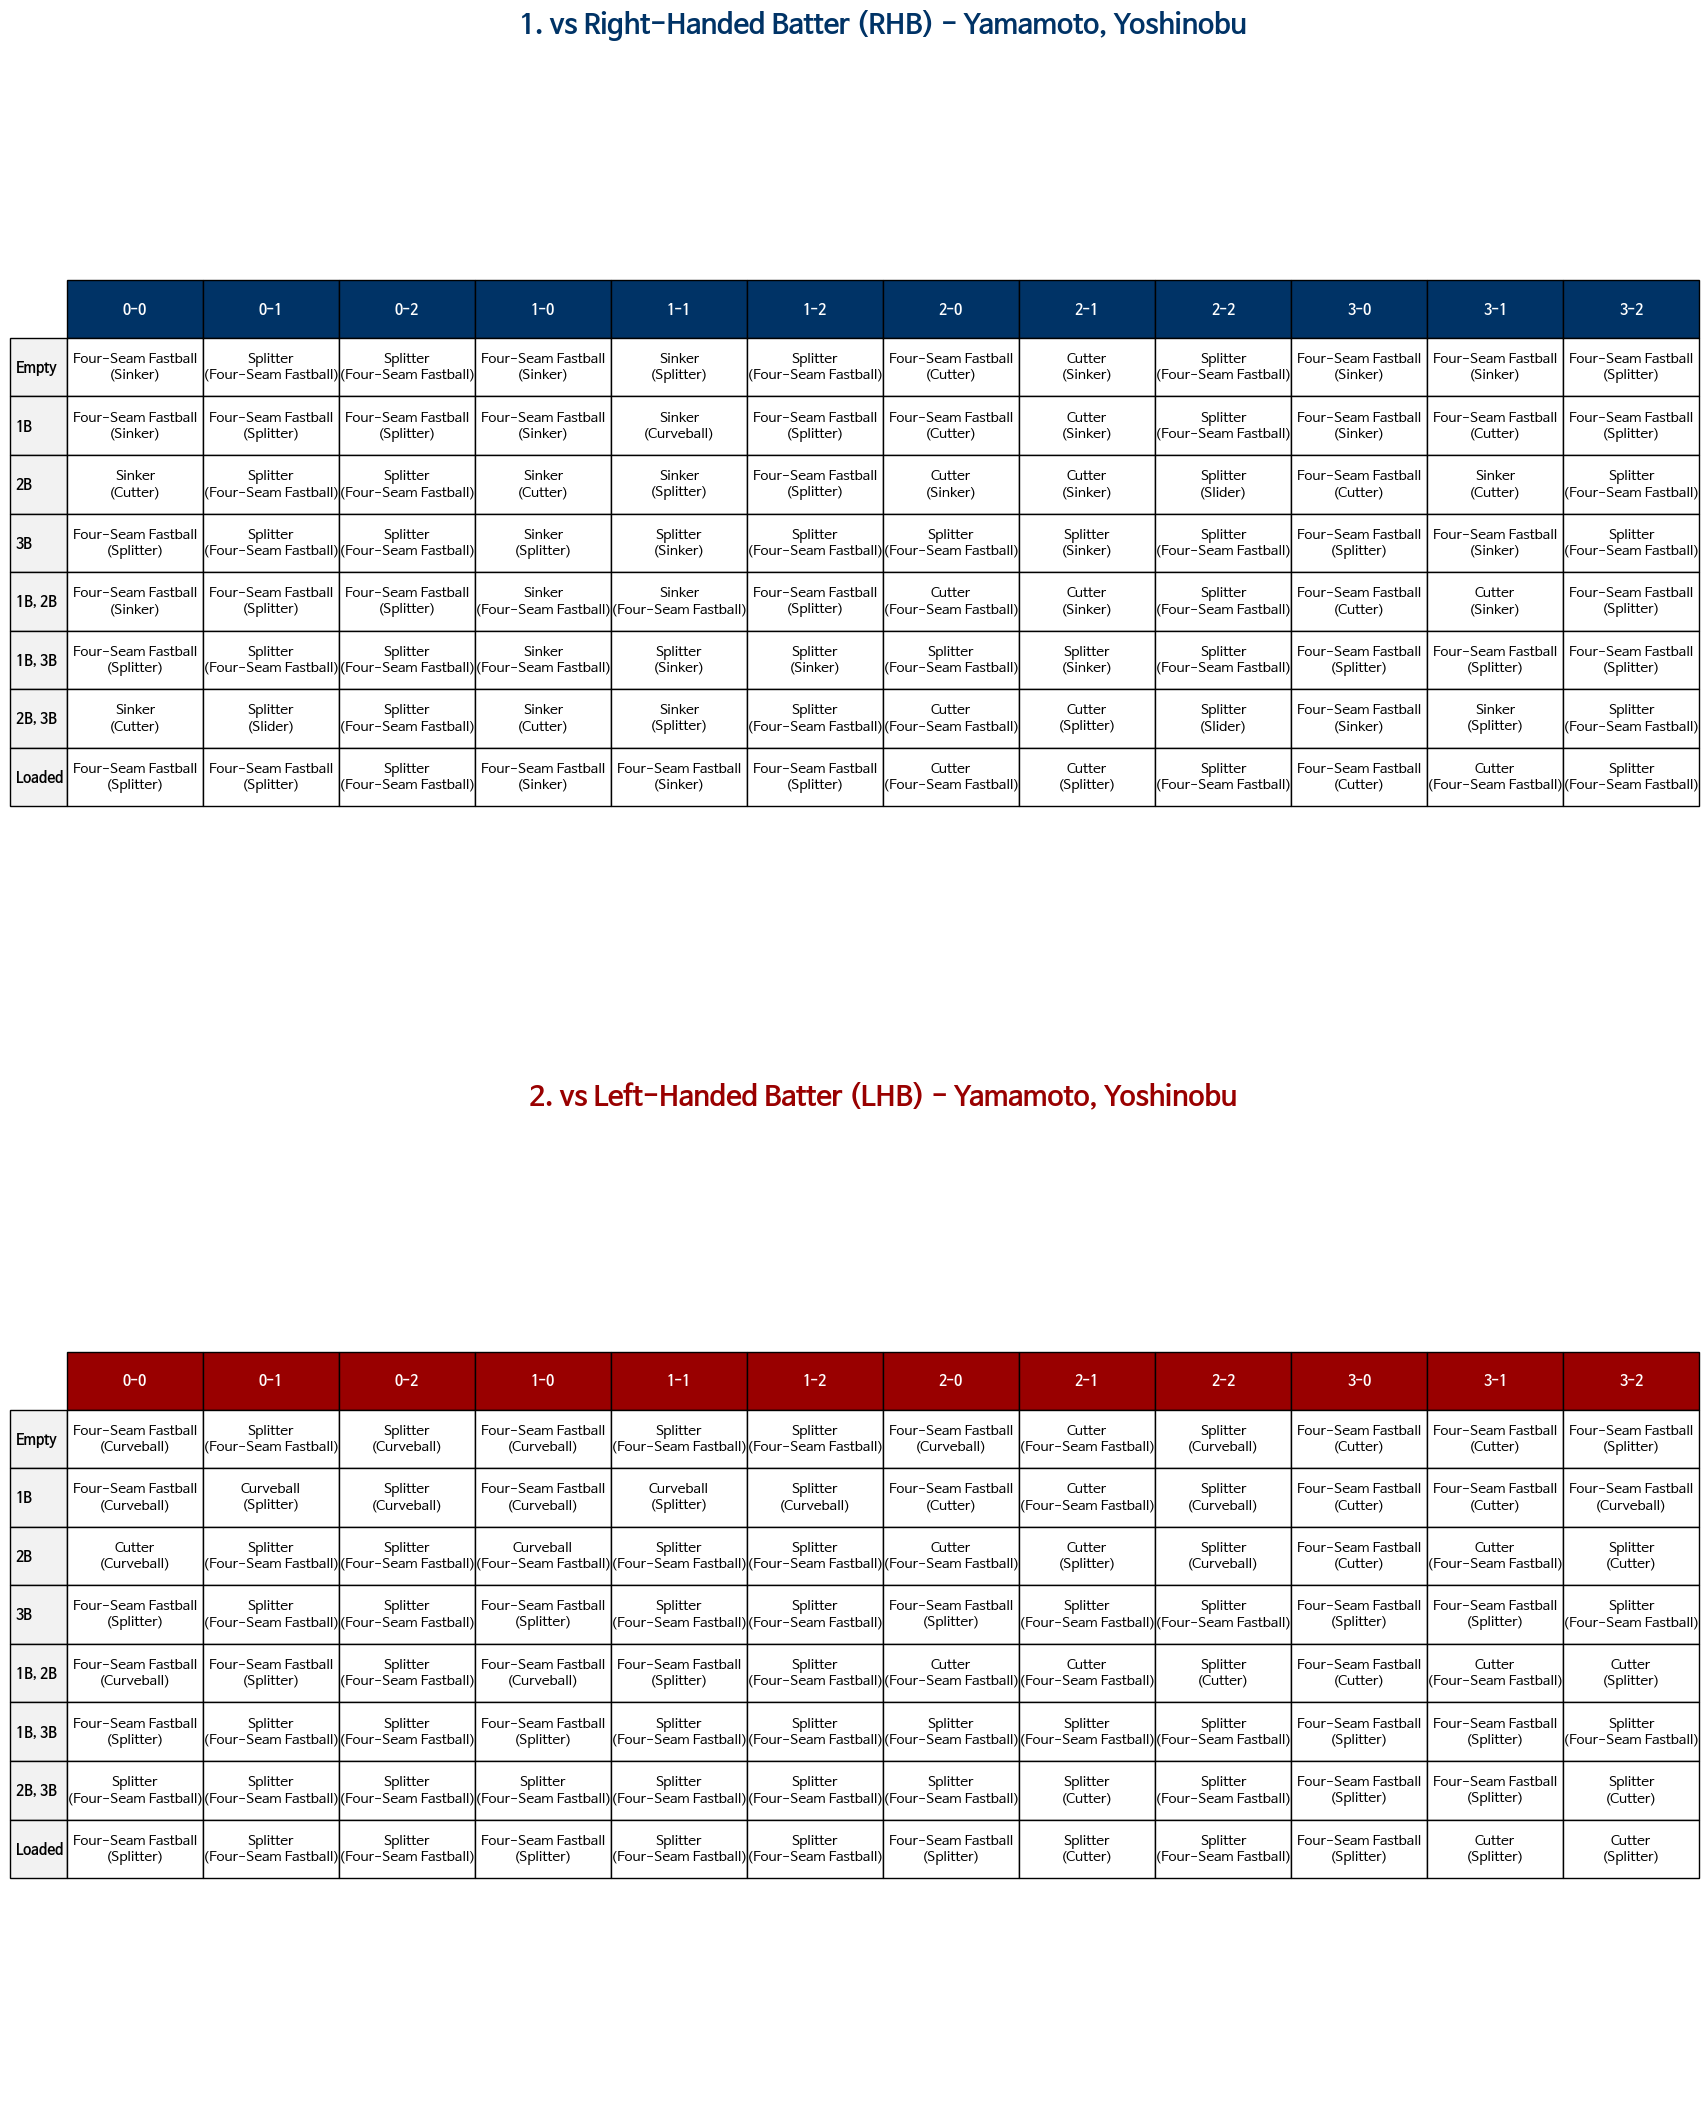

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_strategy_sheet_english(strategy_df, pitcher_name):
    # 1. 한글 -> 영어 매핑 사전 정의
    runner_translation = {
        '주자 없음': 'Empty',
        '1루': '1B', '2루': '2B', '3루': '3B',
        '1루,2루': '1B, 2B', '1루,3루': '1B, 3B', '2루,3루': '2B, 3B',
        '만루': 'Loaded'
    }

    # 정렬 순서 (Runners Order)
    runner_order = ['Empty', '1B', '2B', '3B', '1B, 2B', '1B, 3B', '2B, 3B', 'Loaded']

    # 2. 데이터 가공 함수
    def get_english_pivot(korean_batter_type):
        # 해당 타자 필터링
        sub_df = strategy_df[strategy_df['타자'] == korean_batter_type].copy()

        # 주자 상황 영어로 변환
        sub_df['Runners'] = sub_df['주자'].map(runner_translation)

        # 1순위 / 2순위 구종 병합 (줄바꿈 \n 포함)
        # 1순위가 이미 영어(Pitch Name)라면 그대로 두고, 혹시 한글이면 매핑 필요하지만
        # 이전 코드에서 pitch_type_names(영어)를 썼으므로 그대로 씁니다.
        sub_df['Combined'] = sub_df.apply(
            lambda x: f"{x['1순위']}\n({x['2순위']})" if x['2순위'] else x['1순위'],
            axis=1
        )

        # Pivot Table 생성 (Index: Runners, Column: Count, Value: Pitch)
        pivot = sub_df.pivot(index='Runners', columns='볼카운트', values='Combined')

        # 주자 순서 정렬
        pivot = pivot.reindex(runner_order)
        return pivot

    # 3. 우타자(RHB) / 좌타자(LHB) 데이터 준비
    # strategy_df에는 '우타자(R)', '좌타자(L)'로 저장되어 있음
    df_rhb = get_english_pivot("우타자(R)")
    df_lhb = get_english_pivot("좌타자(L)")

    # 4. 시각화 (2개의 Subplot)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 22)) # 세로 길이 넉넉하게

    # 공통 테이블 그리기 함수
    def draw_table(ax, df, title, header_color):
        ax.axis('tight')
        ax.axis('off')

        # 테이블 생성
        table = ax.table(cellText=df.values,
                         rowLabels=df.index,
                         colLabels=df.columns,
                         cellLoc='center',
                         loc='center')

        # 스타일링
        table.auto_set_font_size(False)
        table.set_fontsize(10)       # 글자 크기
        table.scale(1.0, 2.8)        # 셀 높이 (줄바꿈 된 글자 잘 보이게)

        # 색상 및 폰트 설정
        for (row, col), cell in table.get_celld().items():
            if row == 0: # 헤더 (볼카운트)
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor(header_color)
                cell.set_height(0.06)
            elif col == -1: # 행 인덱스 (주자)
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#f2f2f2') # 연회색
            else:
                # 데이터 셀 (줄바꿈 허용)
                cell.set_text_props(wrap=True)

        ax.set_title(title, fontsize=20, weight='bold', pad=20, color=header_color)

    # 5. 그리기 실행
    # (1) Right-Handed Batter (Blue Theme)
    draw_table(ax1, df_rhb,
               f"1. vs Right-Handed Batter (RHB) - {pitcher_name}",
               '#003366')

    # (2) Left-Handed Batter (Red Theme)
    draw_table(ax2, df_lhb,
               f"2. vs Left-Handed Batter (LHB) - {pitcher_name}",
               '#990000')

    plt.tight_layout(pad=4.0)
    plt.show()

# 함수 실행
plot_strategy_sheet_english(strategy_df, pitcher_name)